## Data preparation for a blog post on vegetation fires on Table Mountain

After downloading files from [the City of Cape Town
portal](https://web1.capetown.gov.za/web1/OpenDataPortal/DatasetDetail?DatasetName=Fire%20incidence) I manually converted them to xls files. Since years up to 2016 are in spreadsheet format and from 2017 as a database dump I had to process them differently.

In [97]:
from os import listdir
from os.path import join, isfile
import pandas as pd

In [98]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

%matplotlib inline

In [99]:
path = '/home/cape_town_data/'
datfiles = [f for f in listdir(path) if isfile(join(path, f))]
xl_files = [s for s in datfiles if s[-3:] == 'xls']
xl_files

['Fire Incidence  April  - June  2017.xls',
 'Fire incidence Jan 2009 - Jan 2016.xls',
 'Fire incidence Jan 2016 - Mar 2016.xls',
 'Fire incidence January - March 2017.xls',
 'Fire incidence Jul16 - Sep16.xls',
 'Fire Incidence July - September 2017.xls',
 'Fire_Incidence_Apr_2016_Jun_2016.xls']

In [100]:
xl_files_17 = [s for s in xl_files if s[-8:-4] == '2017']
xl_files_16 = [s for s in xl_files if s[-6:-4] == '16']

### Spreadsheet format

First I cleaned up column names as they differ slightly in every file.

In [101]:
columns = ['Incident number',
           'Incident category',
           'Incident sub-category',
           'Date of IncidentD',
           'Time of IncidentMT',
           'Callers Statement',
           'Location',
           'Street',
           'Suburb',
           'Town',
           'Equipment used',
           'FPA Classification',
           'FPA Occupancy',
           'Weather',
           'Wind',
           'Temperature',
           'What Was Burning',
           'Description of Incident',
           'Actions of Brigade',
           'FPA Suspected Cause',
           'Details of cause',
           'Fire Damage - Details',
           'District',
           'Station/S Responded',
           'Fire Category',
           'NESD update control', 
           'Source_of_water']
new_cols = [c.rstrip().lstrip().replace(" ", "_") for c in columns]
frames = []
for x in xl_files_16:
    xl = pd.ExcelFile(join(path, x))
    df = xl.parse("Vegetation")
    # strip leading and trailing space
    new_c = [c.rstrip().lstrip().replace(" ", "_") for c in df.columns]
    df.columns = new_c
    frames.append(df)
result = pd.concat(frames)
df16 = result[new_cols].copy()
df16.head()

,Incident_number,Incident_category,Incident_sub-category,Date_of_IncidentD,Time_of_IncidentMT,Callers_Statement,Location,Street,Suburb,Town,...,Description_of_Incident,Actions_of_Brigade,FPA_Suspected_Cause,Details_of_cause,Fire_Damage_-_Details,District,Station/S_Responded,Fire_Category,NESD_update_control,Source_of_water
0,F0901/0001,Other,Rubbish/Grass/Bush,2009-01-01,00:03|00:04|00:04|00:04,Vegetation Alight,NaN,BUREN STREET,BOTHASIG,BLAAUWBERG,...,False Alarm,No Call Found,NaN,False Alarm,NaN,North,Milnerton,Category 1|No Charge,1.294044e+09,NaN
1,F0901/0002,Other,Rubbish/Grass/Bush,2009-01-01,00:07|00:08|00:08|00:08,Reeds Alight,Sandvlei Wetland Reserve,Lake Road,FROGMORE ESTATE,SOUTH PENINSULA,...,Minor Vegetation Fire,Extinguished With Two Fog Jets From Whiskey 14...,Other,Ignited Signal Flare Dropping Into Reeds And I...,Small Area Of Reeds Burnt.,West,Lakeside,"Category 2|Bush, Grass, Vegetation",1.384005e+09,WT
2,F0901/0004,Other,Rubbish/Grass/Bush,2009-01-01,00:16|00:17|00:17|00:17,Vegetation Alight,Close To The Indoor Centre,Tafelberg Road,TAFELSIG,CAPE TOWN,...,Minor Vegetation Fire,Extinguished Fire With 1xfogjet From E.27(1000...,Undetermined,Unknown,NaN,East,Lansdowne,"Category 2|Bush, Grass, Vegetation",1.353403e+09,MP
3,F0901/0006,Other,Rubbish/Grass/Bush,2009-01-01,00:20|00:21|00:21|00:21,Vegetation Alight,NaN,Karria Street,ATLANTIS,BLAAUWBERG,...,False Alarm,Nil,Other,Undetermined,NaN,North,Atlantis,"Category 2|Bush, Grass, Vegetation",1.294044e+09,NaN
4,F0901/0007,Other,Rubbish/Grass/Bush,2009-01-01,00:22|00:22|00:22|00:22,Tyres Alight,NaN,JAKKALSVLEI AVENUE,BONTEHEUWEL,CAPE TOWN,...,Rubbish Fire,Extinguished With One Fog Jet From W18 Water T...,Open Flames,Passer-By Dropping Alight,Small Quantity Of Tyres Burned,North,Epping,"Category 2|Bush, Grass, Vegetation",1.467973e+09,WT


Now I combined two columns, Date of incident and Time of incident, into one column with timestamp.

In [102]:
def time2date(date_ts, time_str):
    if type(time_str) is str:
        t = time_str.split('|')[0].split(':')
        d = date_ts.replace(hour=int(t[0]), minute=int(t[1]))
    elif type(time_str) is float:
        t = [0, 0]
        d = date_ts.replace(hour=int(t[0]), minute=int(t[1]))
    else:
        d = date_ts.replace(hour=time_str.hour, minute=time_str.minute)
    return d

In [103]:
dt_vec = [time2date(df16['Date_of_IncidentD'].iloc[d], 
                    df16['Time_of_IncidentMT'].iloc[d]) 
          for d in range(len(result))]

df16['Datetime'] = dt_vec
df16 = df16.sort_values('Datetime')
df16 = df16.reset_index(drop=True)

We can drop those redundant columns now.

In [104]:
df16.drop(['Date_of_IncidentD', 'Time_of_IncidentMT', 'NESD_update_control'], 
        axis=1,
        inplace=True)
df16.head()

,Incident_number,Incident_category,Incident_sub-category,Callers_Statement,Location,Street,Suburb,Town,Equipment_used,FPA_Classification,...,Description_of_Incident,Actions_of_Brigade,FPA_Suspected_Cause,Details_of_cause,Fire_Damage_-_Details,District,Station/S_Responded,Fire_Category,Source_of_water,Datetime
0,F0901/0001,Other,Rubbish/Grass/Bush,Vegetation Alight,NaN,BUREN STREET,BOTHASIG,BLAAUWBERG,NaN,False Alarm - Malicious,...,False Alarm,No Call Found,NaN,False Alarm,NaN,North,Milnerton,Category 1|No Charge,NaN,2009-01-01 00:03:00
1,F0901/0002,Other,Rubbish/Grass/Bush,Reeds Alight,Sandvlei Wetland Reserve,Lake Road,FROGMORE ESTATE,SOUTH PENINSULA,2 X Hosereels,Fire - manually extinguished,...,Minor Vegetation Fire,Extinguished With Two Fog Jets From Whiskey 14...,Other,Ignited Signal Flare Dropping Into Reeds And I...,Small Area Of Reeds Burnt.,West,Lakeside,"Category 2|Bush, Grass, Vegetation",WT,2009-01-01 00:07:00
2,F0901/0004,Other,Rubbish/Grass/Bush,Vegetation Alight,Close To The Indoor Centre,Tafelberg Road,TAFELSIG,CAPE TOWN,1xfogjet,Fire - manually extinguished,...,Minor Vegetation Fire,Extinguished Fire With 1xfogjet From E.27(1000...,Undetermined,Unknown,NaN,East,Lansdowne,"Category 2|Bush, Grass, Vegetation",MP,2009-01-01 00:16:00
3,F0901/0006,Other,Rubbish/Grass/Bush,Vegetation Alight,NaN,Karria Street,ATLANTIS,BLAAUWBERG,Nil,False Alarm - Malicious,...,False Alarm,Nil,Other,Undetermined,NaN,North,Atlantis,"Category 2|Bush, Grass, Vegetation",NaN,2009-01-01 00:20:00
4,F0901/0007,Other,Rubbish/Grass/Bush,Tyres Alight,NaN,JAKKALSVLEI AVENUE,BONTEHEUWEL,CAPE TOWN,One X Hose Reel,Fire - manually extinguished,...,Rubbish Fire,Extinguished With One Fog Jet From W18 Water T...,Open Flames,Passer-By Dropping Alight,Small Quantity Of Tyres Burned,North,Epping,"Category 2|Bush, Grass, Vegetation",WT,2009-01-01 00:22:00


In [105]:
list(df16)

['Incident_number',
 'Incident_category',
 'Incident_sub-category',
 'Callers_Statement',
 'Location',
 'Street',
 'Suburb',
 'Town',
 'Equipment_used',
 'FPA_Classification',
 'FPA_Occupancy',
 'Weather',
 'Wind',
 'Temperature',
 'What_Was_Burning',
 'Description_of_Incident',
 'Actions_of_Brigade',
 'FPA_Suspected_Cause',
 'Details_of_cause',
 'Fire_Damage_-_Details',
 'District',
 'Station/S_Responded',
 'Fire_Category',
 'Source_of_water',
 'Datetime']

### Database dump

In [106]:
frames = []
for x in xl_files_17:
    xl = pd.ExcelFile(join(path, x))
    df = xl.parse("Sheet1")
    frames.append(df)
df17 = pd.concat(frames)
df17.head()

,Action Prior to Arrival,Created At,Equipment Used,FPA - Comment,FPA - Details Of Cause,FPA - FPA classification:,FPA- FPA Occupancy,How Extinguished - Action of brigade,How Extinguished - Description of incident,How Extinguished - What was Burning,...,Suburb,Temperature,Unnamed: 11,Unnamed: 14,Water Source - Source Of Water,Water Source - Water Used,Water Source - Water Used Charged,Water Source - Water Used Un(Quantity),Weather,Wind
0,Nil,2017-04-01 01:21:58,15 - 20 min,Suspected candle knocked over.,NaN,Fire manually extinguished,NaN,Extinguished using one jet from E47.,Minor Structural Fire,Contents of structure,...,LEIDEN,15 - 20 Deg,NaN,NaN,Water Tanker,NaN,0,NaN,Fine,Light Breeze
1,Nil,2017-04-01 01:21:58,15 - 20 min,Suspected candle knocked over.,NaN,Fire manually extinguished,NaN,Extinguished using one jet from E47.,Minor Structural Fire,Contents of structure,...,LEIDEN,15 - 20 Deg,NaN,NaN,NaN,NaN,0,NaN,Fine,Light Breeze
2,Nil,2017-04-01 01:21:58,NaN,Suspected candle knocked over.,NaN,Fire manually extinguished,NaN,Extinguished using one jet from E47.,Minor Structural Fire,Contents of structure,...,LEIDEN,15 - 20 Deg,NaN,NaN,NaN,NaN,0,NaN,Fine,Light Breeze
3,NaN,2017-04-01 04:09:43,NaN,NaN,Short Circuit,Fire manually extinguished,NaN,Extinguished fire with 1 x fog jet from E08 an...,Average Structural Fire,"Furniture, motorbike and tools",...,SURREY,10 - 15 Deg,NaN,NaN,Street Hydrant,NaN,0,NaN,Fine,Light Breeze
4,"Motor vehicle accident, 2 x adult males ( yell...",2017-04-01 04:50:12,NaN,Motor vehicle accident,NaN,Special Service,NaN,Brigade stood by to make roadway safe,Special Service,NaN,...,SANDDRIFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We see already that column names are different and we have plenty of new ones. Lets delete the ones that are not present in our earlier spreadsheet files and rename the rest.

In [107]:
del_cols = ['Action Prior to Arrival',
            'No of Units',
            'Premises Details - No Of Floors',
            'Premises Details - Occupier Driver',
            'Premises Details - Owner',
            'Property Damage - Fire Damage Build Vehicle',
            'Property Damage - Fire Damage Content',
            'Property Damage - Fire Damage Details Building',
            'Resolution Code - Comment',
            'Service Request - Sub Council',
            'Service Request - Ward',
            'Street No',
            'Unnamed: 11',
            'Unnamed: 14',
            'Water Source - Water Used',
            'Water Source - Water Used Charged',
            'Water Source - Water Used Un(Quantity)']
df17.drop(del_cols, axis=1, inplace=True)
df17.rename(columns={'Created At': 'Datetime',
                     'Equipment Used': 'Equipment_used',
                     'FPA- FPA Occupancy': 'FPA_Occupancy',
                     'How Extinguished - Action of brigade': 'Actions_of_Brigade',
                     'Responsible Entity - District': 'District',
                     'Service Request - Category': 'Incident_category',
                     'Service Request - Sub Category': 'Incident_sub-category',
                     'Service_Request': 'Incident_number',
                     'FPA - FPA classification:': 'FPA_Classification',
                     'Property Damage - Remarks': 'Fire_Damage_-_Details',
                     'How Extinguished - What was Burning': 'What_Was_Burning',
                     'FPA - Details Of Cause': 'Details_of_cause',
                     'How Extinguished - Description of incident': 'Description_of_Incident',
                     'Water Source - Source Of Water': 'Source_of_water'}, 
            inplace=True)
df17.head()

,Datetime,Equipment_used,FPA - Comment,Details_of_cause,FPA_Classification,FPA_Occupancy,Actions_of_Brigade,Description_of_Incident,What_Was_Burning,Fire_Damage_-_Details,...,Service Request - Area,Incident_category,Incident_sub-category,Incident_number,Street,Suburb,Temperature,Source_of_water,Weather,Wind
0,2017-04-01 01:21:58,15 - 20 min,Suspected candle knocked over.,NaN,Fire manually extinguished,NaN,Extinguished using one jet from E47.,Minor Structural Fire,Contents of structure,On arrival brigade found one wood and iron str...,...,East,RESIDENTIAL FIRE,RESIDENTIAL FIRE - INFORMAL,30019766,LEIDEN AVENUE,LEIDEN,15 - 20 Deg,Water Tanker,Fine,Light Breeze
1,2017-04-01 01:21:58,15 - 20 min,Suspected candle knocked over.,NaN,Fire manually extinguished,NaN,Extinguished using one jet from E47.,Minor Structural Fire,Contents of structure,On arrival brigade found one wood and iron str...,...,East,RESIDENTIAL FIRE,RESIDENTIAL FIRE - INFORMAL,30019766,LEIDEN AVENUE,LEIDEN,15 - 20 Deg,NaN,Fine,Light Breeze
2,2017-04-01 01:21:58,NaN,Suspected candle knocked over.,NaN,Fire manually extinguished,NaN,Extinguished using one jet from E47.,Minor Structural Fire,Contents of structure,On arrival brigade found one wood and iron str...,...,East,RESIDENTIAL FIRE,RESIDENTIAL FIRE - INFORMAL,30019766,LEIDEN AVENUE,LEIDEN,15 - 20 Deg,NaN,Fine,Light Breeze
3,2017-04-01 04:09:43,NaN,NaN,Short Circuit,Fire manually extinguished,NaN,Extinguished fire with 1 x fog jet from E08 an...,Average Structural Fire,"Furniture, motorbike and tools",All persons accounted for and 1 x person displ...,...,West,RESIDENTIAL FIRE,RESIDENTIAL FIRE - FORMAL,30019767,KIM ROAD,SURREY,10 - 15 Deg,Street Hydrant,Fine,Light Breeze
4,2017-04-01 04:50:12,NaN,Motor vehicle accident,NaN,Special Service,NaN,Brigade stood by to make roadway safe,Special Service,NaN,Upon arrival it was found 2 x motor vehicles i...,...,North,MOTOR VEHICLE ACCIDENT,PEDESTRIAN VEHICLE ACCIDENT (PVA ),30019768,BOSMANSDAM ROAD,SANDDRIFT,NaN,NaN,NaN,NaN


A bit more cleaning.

In [108]:
df17 = df17[df17['Incident_number'].map(type) != str]
df17.drop(df17[df17['Datetime'].isnull()].index, inplace=True)
df17 = df17[df17['Datetime'].map(type) != str]
df17 = df17[df17['Incident_number'].map(type) == int]

In [109]:
list(df17)

['Datetime',
 'Equipment_used',
 'FPA - Comment',
 'Details_of_cause',
 'FPA_Classification',
 'FPA_Occupancy',
 'Actions_of_Brigade',
 'Description_of_Incident',
 'What_Was_Burning',
 'Fire_Damage_-_Details',
 'District',
 'Service Request - Area',
 'Incident_category',
 'Incident_sub-category',
 'Incident_number',
 'Street',
 'Suburb',
 'Temperature',
 'Source_of_water',
 'Weather',
 'Wind']

### Combine similar columns from both xls

In [110]:
list(set(df17).intersection(list(df16)))

['Incident_sub-category',
 'FPA_Classification',
 'Suburb',
 'Incident_category',
 'Wind',
 'Actions_of_Brigade',
 'Street',
 'Temperature',
 'Details_of_cause',
 'What_Was_Burning',
 'Source_of_water',
 'Fire_Damage_-_Details',
 'Datetime',
 'Incident_number',
 'Weather',
 'District',
 'Equipment_used',
 'Description_of_Incident',
 'FPA_Occupancy']

In [111]:
final_cols = list(set(df17).intersection(list(df16)))
f16 = df16[final_cols].copy()
f17 = df17[final_cols].copy()
final_result = pd.concat([f16, f17])
len(final_result)

93022

Get rid of NaN timestamps.

In [112]:
final_result = final_result[pd.notnull(final_result['Datetime'])]
final_result = final_result.drop_duplicates(subset='Datetime', 
                                            keep="first")
len(final_result)

88480

Save to csv.

In [113]:
# final_result.to_csv('fire_log_cape_town.csv', 
#                     encoding='utf-8',
#                     index=False)

## Blog plots

In [114]:
csv_path = 'fire_log_cape_town.csv'
df = pd.read_csv(join(path, csv_path), parse_dates=['Datetime'])
df.head()

,Incident_category,District,Description_of_Incident,Wind,Details_of_cause,Source_of_water,Temperature,Fire_Damage_-_Details,Suburb,FPA_Classification,Street,What_Was_Burning,Equipment_used,Incident_number,Weather,FPA_Occupancy,Incident_sub-category,Actions_of_Brigade,Datetime
0,Other,North,False Alarm,NaN,False Alarm,NaN,NaN,NaN,BOTHASIG,False Alarm - Malicious,BUREN STREET,NaN,NaN,F0901/0001,NaN,NaN,Rubbish/Grass/Bush,No Call Found,2009-01-01 00:03:00
1,Other,West,Minor Vegetation Fire,Light Breeze,Ignited Signal Flare Dropping Into Reeds And I...,WT,10 - 15 Deg,Small Area Of Reeds Burnt.,FROGMORE ESTATE,Fire - manually extinguished,Lake Road,Small Area Of Reeds,2 X Hosereels,F0901/0002,Fine,"Other|Rubbish, Grass & Bush",Rubbish/Grass/Bush,Extinguished With Two Fog Jets From Whiskey 14...,2009-01-01 00:07:00
2,Other,East,Minor Vegetation Fire,Light Breeze,Unknown,MP,15 - 20 Deg,NaN,TAFELSIG,Fire - manually extinguished,Tafelberg Road,Grass,1xfogjet,F0901/0004,Fine,"Other|Rubbish, Grass & Bush",Rubbish/Grass/Bush,Extinguished Fire With 1xfogjet From E.27(1000...,2009-01-01 00:16:00
3,Other,North,False Alarm,Moderate,Undetermined,NaN,15 - 20 Deg,NaN,ATLANTIS,False Alarm - Malicious,Karria Street,Nil,Nil,F0901/0006,Fine,"Other|Rubbish, Grass & Bush",Rubbish/Grass/Bush,Nil,2009-01-01 00:20:00
4,Other,North,Rubbish Fire,Light Breeze,Passer-By Dropping Alight,WT,15 - 20 Deg,Small Quantity Of Tyres Burned,BONTEHEUWEL,Fire - manually extinguished,JAKKALSVLEI AVENUE,Tyres,One X Hose Reel,F0901/0007,Fine,"Other|Rubbish, Grass & Bush",Rubbish/Grass/Bush,Extinguished With One Fog Jet From W18 Water T...,2009-01-01 00:22:00


In [115]:
df['Datetime'].min()

Timestamp('2009-01-01 00:03:00')

In [116]:
df['Datetime'].max()

Timestamp('2017-09-30 23:26:01')

See how many fires happen on each day of the week.

In [117]:
week_df = df.groupby(df['Datetime'].dt.weekday_name).count()
print(week_df['Incident_number'])

Datetime
Friday       12891
Monday       12685
Saturday     12768
Sunday       12524
Thursday     12553
Tuesday      12864
Wednesday    12195
Name: Incident_number, dtype: int64


Text(0.5,0,'Day of the week')

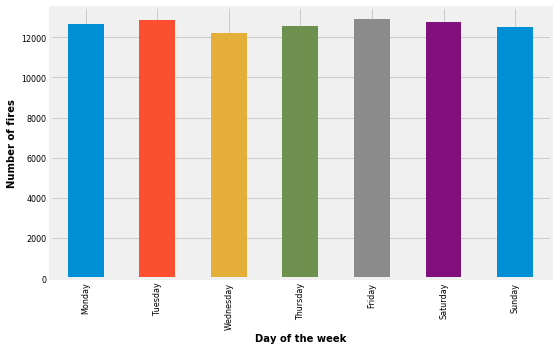

In [118]:
field = "Day"
day_order = ["Monday", "Tuesday", "Wednesday", 
             "Thursday", "Friday", "Saturday", "Sunday"]
ax = week_df['Incident_number'].loc[day_order].plot(kind="bar", 
                                                    legend=False,
                                                   figsize=(8,5));
ax.set_ylabel("Number of fires")
ax.set_xlabel("Day of the week")

See how many vegetation fires happen on each day of the week.

In [119]:
fire_type = df['Description_of_Incident'].unique().tolist()
fire_type = [x for x in fire_type if str(x) != 'nan']
veg_fire = [s for s in fire_type if 'Vegetation' in s]

df_fire = df.loc[df['Description_of_Incident'].isin(veg_fire)]
veg_week_df = df_fire.groupby(df_fire['Datetime'].dt.weekday_name).count()
print(veg_week_df['Incident_number'])

Datetime
Friday       5810
Monday       5669
Saturday     5537
Sunday       5653
Thursday     5527
Tuesday      5791
Wednesday    5417
Name: Incident_number, dtype: int64


Text(0.5,0,'Day of the week')

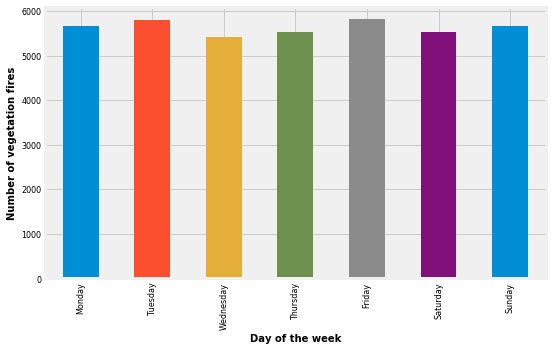

In [120]:
ax = veg_week_df['Incident_number'].loc[day_order].plot(kind="bar", 
                                                        legend=False, 
                                                   figsize=(8,5));
ax.set_ylabel("Number of vegetation fires")
ax.set_xlabel("Day of the week")

Look only at Table Mountain park.

In [121]:
def capitalise(sub_str):
    if type(sub_str) is float:
        s = sub_str
    else:
        s = sub_str.title()
    return s

In [122]:
dff = df_fire.copy()
dff['Suburb'] = df_fire['Suburb'].apply(capitalise)
fire_suburb = dff['Suburb'].unique().tolist()
fire_suburb = [x for x in fire_suburb if str(x) != 'nan']
tm_park = ['Table Mountain', 'Signal Hill', "Oudekraal",
          "Wynberg Nu", 'Lions Head', 'Signal Hill / Lions Head',
          'Silvermine', 'Cape Point']

m_fire = [s for s in fire_suburb if s in tm_park]
m_fire

['Signal Hill',
 'Oudekraal',
 'Table Mountain',
 'Cape Point',
 'Silvermine',
 'Signal Hill / Lions Head',
 'Wynberg Nu']

In [123]:
df_table = dff.loc[dff['Suburb'].isin(m_fire)]
df_table = df_table.reset_index()
len(df_table)

39

In [124]:
tm_week_df = df_table.groupby(df_table['Datetime'].dt.weekday_name).count()
print(tm_week_df['Incident_number'])

Datetime
Friday        4
Monday        4
Saturday      5
Sunday       11
Thursday      4
Tuesday       6
Wednesday     5
Name: Incident_number, dtype: int64


Text(0.5,0,'Day of the week')

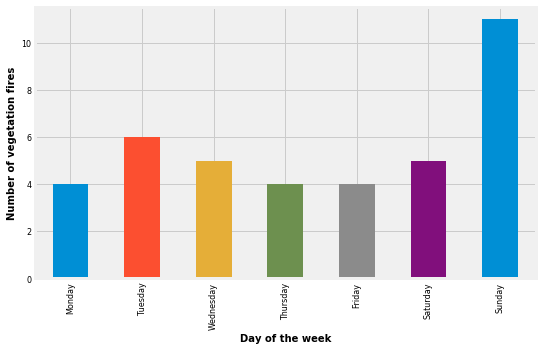

In [125]:
ax = tm_week_df['Incident_number'].loc[day_order].plot(kind="bar", 
                                                       legend=False, 
                                                   figsize=(8,5));
ax.set_ylabel("Number of vegetation fires")
ax.set_xlabel("Day of the week")

Plot frequency of fires per month.

In [126]:
dff = dff.reset_index().set_index('Datetime')
dff = dff[dff['Incident_number'].index.notnull()]
dff.loc[:, 'index'] = 1

In [127]:
dff.head()

,index,Incident_category,District,Description_of_Incident,Wind,Details_of_cause,Source_of_water,Temperature,Fire_Damage_-_Details,Suburb,FPA_Classification,Street,What_Was_Burning,Equipment_used,Incident_number,Weather,FPA_Occupancy,Incident_sub-category,Actions_of_Brigade
Datetime,,,,,,,,,,,,,,,,,,,
2009-01-01 00:07:00,1,Other,West,Minor Vegetation Fire,Light Breeze,Ignited Signal Flare Dropping Into Reeds And I...,WT,10 - 15 Deg,Small Area Of Reeds Burnt.,Frogmore Estate,Fire - manually extinguished,Lake Road,Small Area Of Reeds,2 X Hosereels,F0901/0002,Fine,"Other|Rubbish, Grass & Bush",Rubbish/Grass/Bush,Extinguished With Two Fog Jets From Whiskey 14...
2009-01-01 00:16:00,1,Other,East,Minor Vegetation Fire,Light Breeze,Unknown,MP,15 - 20 Deg,NaN,Tafelsig,Fire - manually extinguished,Tafelberg Road,Grass,1xfogjet,F0901/0004,Fine,"Other|Rubbish, Grass & Bush",Rubbish/Grass/Bush,Extinguished Fire With 1xfogjet From E.27(1000...
2009-01-01 01:25:00,1,Other,North,Minor Vegetation Fire,Moderate,Unknown,MP,15 - 20 Deg,Small Area Of Grass,Epping 1,Fire - manually extinguished,OFF GUNNERS CIRCLE,Grass,1x Jet From Whiskey 19,F0901/0020,Clear,"Other|Rubbish, Grass & Bush",Rubbish/Grass/Bush,Fire Extinguished And Area Made Safe
2009-01-01 01:44:00,1,Other,North,Minor Vegetation Fire,Light Breeze,Possible Setting Off Of Fire Works Igniting Dr...,MP,15 - 20 Deg,A Medium Area Of Bush And Grass Burned,Klipheuwel,Fire - manually extinguished,Radio Road,Grass,2 X Fogjets,F0901/0025,Fine,"Other|Rubbish, Grass & Bush",Rubbish/Grass/Bush,Extinguished Fire Using Water 1 X Fogjet E04(3...
2009-01-01 02:08:00,1,Other,West,Major Vegetation Fire,Light Breeze,The Heat From A Flair,MP|WT|SH,15 - 20 Deg,NaN,Lekkerwater,Fire - manually extinguished,KANANA STREET,Reeds And Grass,4 X Hose Reels,F0901/0029,Fine,"Other|Rubbish, Grass & Bush",Rubbish/Grass/Bush,Extinguished Fire Using 1 Fog From E17 1 Fog F...


In [128]:
fire_month = dff['index'].resample('M').sum().to_period(freq='M')
fire_month.rename(columns={'index': 'sum'}, inplace=True)
fire_month.head()
weekends = fire_month.index.month.isin([12,1])

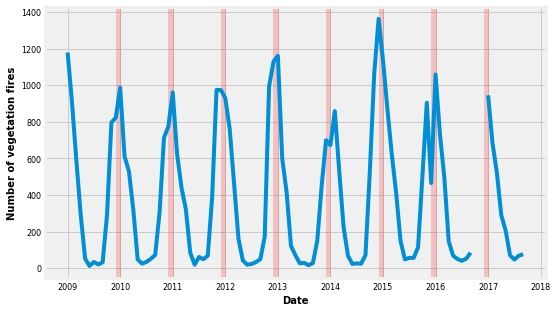

In [129]:
n = 3

ax = fire_month.plot(figsize=(8,5),  legend=False)
ax.ticklabel_format(style='plain', axis='y')
ax.set_ylabel("Number of vegetation fires")
ax.set_xlabel("Date")

times = fire_month.loc[weekends].index
begins, ends = times[1:-1:2], times[2::2]
for begin, end in zip(begins, ends):
    ax.axvspan(begin, end, color='red', alpha=0.2)